In [23]:
import json
import pandas as pd
from PIL import Image, ImageDraw
import requests
from io import BytesIO
import pandas as pd
import uuid
import numpy as np
import cv2
import glob

In [2]:
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows', 200)


In [4]:
class Page:
    def __init__(self,input_file,local=False):
        self.file = input_file
        self.local = local
        self.get_json()
        
    def get_json(self):
        if self.local :
            with open(self.file) as f :
                self.json = json.load(f)
        else :
            file_name = self.file['input']['name']
            r = requests.get('https://auth.anuvaad.org/download/' + file_name)
            self.json = r.json()
        
    def get_page(self,page_index):
        page_path = self.json['rsp']['outputs'][0]['page_info'][page_index]
        page_path = '/'.join(page_path.split('/')[1:])
        page_request = requests.get('https://auth.anuvaad.org/download/' + page_path)
        return page_request.content
    
#     def get_page_path(self,page_index):
#         return self.json['rsp']['outputs'][0]['page_info'][page_index]
        
        
        

In [5]:
def draw_box(page_image,compare_corrds, save=False):
    
    #image = Image.open(BytesIO(page_image))
    image = Image.open(page_image)
   
    draw   = ImageDraw.Draw(image)
    
    for region in compare_corrds :
        if region['ground'] != None :
            ground = region['ground']['boundingBox']['vertices']
            draw.rectangle(((ground[2]['x'],  ground[2]['y']), (ground[0]['x'],ground[0]['y'])), outline= 'blue',width=5)

        if region['input'] != None:
            inpu_t = region['input']['boundingBox']['vertices']
            draw.rectangle(((inpu_t[2]['x'],  inpu_t[2]['y']), (inpu_t[0]['x'],inpu_t[0]['y'])), outline= 'red',width=5)

    #save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(str(uuid.uuid1()) + '.png')
    plt.imshow(image)
    return image



def draw_region(page_image,corrds,color='red',  save=False):
    
    #image = Image.open(BytesIO(page_image))
    image = Image.open(page_image)
   
    draw   = ImageDraw.Draw(image)
    
    for region in corrds :
       
            ground = region['boundingBox']['vertices']
            draw.rectangle(((ground[2]['x'],  ground[2]['y']), (ground[0]['x'],ground[0]['y'])), outline= color,width=5)

    if save:
        image.save(str(uuid.uuid1()) + '.png')
   
    return image



def find_erros(eval_data,input_data,iou_threshold):
  
    count_erros = []
    iou_error   = []
    for file_index in range(len(eval_data['rsp']['outputs'])) :
        
        for page_index in range(len(eval_data['rsp']['outputs'][file_index]['pages'])):
           

            print('evaluationg file {} page {}'.format(file_index,page_index))

            page = eval_data['rsp']['outputs'][file_index]['pages'][page_index]
            page_image = input_data['rsp']['outputs'][file_index]['page_info'][page_index]

            regions = {}
            try :
                counts = page['count'] 
                count_diff  = abs(counts['input'] - counts['ground'])
                #print('diff in boxes is {}'.format(count_diff))

               # if count_diff >= count_threshold :
                        #count_erros.append({'file_index' : file_index ,'page_index': page_index,'page':page,'path':page_image})
                avg_iou = pd.DataFrame(page['iou'])['iou'].mean()
                print('avrage page iou is {} \n'.format(pd.DataFrame(page['iou'])['iou'].mean()))
                #regions = {'below_iou_threshold':[],'avg_iou': avg_iou, 'count_diff':count_diff,'count_input':counts['input'],'count_ground':counts['ground'], 'file_index' : file_index ,'page_index': page_index, 'page':page['iou'],'path':page_image}
                regions = {'below_iou_threshold':[],'avg_iou': avg_iou,'count_input':counts['input'],'count_ground':counts['ground'], 'file_index' : file_index ,'page_index': page_index, 'page':page['iou'],'path':page_image}


                for reguion_iou in page['iou']:
                    if reguion_iou['iou'] <= iou_threshold:
                        regions['below_iou_threshold'].append(reguion_iou)

                regions['count_below_iou_threshold']= len(regions['below_iou_threshold'])
                #iou_error.append(regions)

            except :
                pass
            
            iou_error.append(regions)
            
    return iou_error
    
    
    

In [6]:
# image_base_path = '/home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/word-detector/craft/'

# input_path = '/home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/upload/craft_38.json'
# ground_path = '/home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/upload/vision_38.json'

# eval_path = '/home/naresh/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/upload/evaluate_38_word.json'

In [13]:
image_base_path = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/word-detector/craft/upload'

ground_path = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/ocr/google/upload/0-16070828096677043.json'




#Magni_ 0.5
#input_path = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/upload/0-1607093029482609.json'
#words
#eval_path = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/upload/0-16071576929145546.json'
#line
#eval_path = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/upload/0-1607160946359452.json'

#magni 1.0
input_path= '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/upload/magni_1_link_3.json'
#word
#eval_path = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/upload/eval_word_magni_1.json'
#line
eval_path = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/upload/eval_line_magni_1.json'



In [14]:
with open(eval_path) as f :
    eval_data = json.load(f)
 

In [15]:
with open(input_path) as f :
    input_data = json.load(f)


In [16]:
with open(ground_path) as f :
    ground_data= _data = json.load(f)




In [17]:
# inputs = pd.DataFrame(input_data['rsp']['inputs']['inputs'])
# inputs['file'].apply(lambda x : x['name'])

In [18]:
inputs = pd.DataFrame(ground_data['rsp']['inputs'])
inputs['file'].apply(lambda x : x['name'])

0        telugu_3_singlecolumn.pdf
1                        37429.pdf
2                      dict_16.pdf
3       sanskrit_1_multicolumn.pdf
4       gujrati_1_singlecolumn.pdf
5       bengali_1_singlecolumn.pdf
6          hind_1_singlecolumn.pdf
7             gujrati_3_single.pdf
8                        empty.pdf
9          odia_1_singlecolumn.pdf
10       nepali_2_singlecolumn.pdf
11       kannada_1_multicolumn.pdf
12    malayalam_2_singlecolumn.pdf
13         urdu_1_singlecolumn.pdf
14                       35977.pdf
15    malayalam_1_singlecolumn.pdf
16       sindhi_2_singlecolumn.pdf
17      kannada_3_singlecolumn.pdf
18     malayalam_1_multicolumn.pdf
19      assamese_2_siglecoulun.pdf
20           20200804144132705.pdf
21               hindi_1_multi.pdf
22     manipuri_2_singlecolumn.pdf
23       nepali_1_singlecolumn.pdf
24      kannada_1_singlecolumn.pdf
25        tamil_3_singlecolumn.pdf
26       gujrati_1_multicolumn.pdf
27          urdu_1_multicolumn.pdf
28         hindi_1_m

In [19]:
iou_errors =  find_erros(eval_data,input_data,iou_threshold = 0.33)

evaluationg file 0 page 0
avrage page iou is 0.8003669973026326 

evaluationg file 0 page 1
avrage page iou is 0.48462757241126236 

evaluationg file 0 page 2
avrage page iou is 0.36155766574471065 

evaluationg file 0 page 3
avrage page iou is 0.3734359654416086 

evaluationg file 1 page 0
avrage page iou is 0.5803985293059953 

evaluationg file 1 page 1
avrage page iou is 0.23882718210536924 

evaluationg file 1 page 2
avrage page iou is 0.3759579348305041 

evaluationg file 1 page 3
avrage page iou is 0.5020815658422372 

evaluationg file 2 page 0
avrage page iou is 0.6746828711260665 

evaluationg file 3 page 0
avrage page iou is 0.6600835822861911 

evaluationg file 3 page 1
avrage page iou is 0.7264742981623735 

evaluationg file 3 page 2
avrage page iou is 0.7929763370984797 

evaluationg file 3 page 3
avrage page iou is 0.6527233585448092 

evaluationg file 4 page 0
avrage page iou is 0.6205528078795206 

evaluationg file 4 page 1
avrage page iou is 0.8959610054887056 

evaluat


evaluationg file 50 page 4
avrage page iou is 0.5891158243435102 

evaluationg file 51 page 0
avrage page iou is 0.6875536991095227 

evaluationg file 51 page 1
avrage page iou is 0.5064846626404149 

evaluationg file 51 page 2
avrage page iou is 0.7613696151627736 

evaluationg file 51 page 3
avrage page iou is 0.7628684954670105 

evaluationg file 52 page 0
avrage page iou is 0.4334985326945525 

evaluationg file 52 page 1
avrage page iou is 0.6053707098352792 

evaluationg file 52 page 2
avrage page iou is 0.5198301727021116 



In [20]:
erro_df = pd.DataFrame(iou_errors)

erro_df.columns

Index(['below_iou_threshold', 'avg_iou', 'count_input', 'count_ground',
       'file_index', 'page_index', 'page', 'path',
       'count_below_iou_threshold'],
      dtype='object')

In [21]:
to_display= ['file_index', 'page_index','avg_iou','count_input', 'count_ground','count_below_iou_threshold']
erro_df[to_display]#.to_csv('results/line_magni_1.csv',index=False)

file_index  page_index   avg_iou  count_input  count_ground  \
0           0.0         0.0  0.800367         41.0          41.0   
1           0.0         1.0  0.484628         13.0           9.0   
2           0.0         2.0  0.361558         99.0          44.0   
3           0.0         3.0  0.373436        100.0          47.0   
4           1.0         0.0  0.580399         49.0          58.0   
5           1.0         1.0  0.238827        154.0          53.0   
6           1.0         2.0  0.375958        118.0          63.0   
7           1.0         3.0  0.502082         76.0          61.0   
8           2.0         0.0  0.674683        117.0          91.0   
9           3.0         0.0  0.660084         14.0          12.0   
10          3.0         1.0  0.726474         69.0          73.0   
11          3.0         2.0  0.792976         27.0          25.0   
12          3.0         3.0  0.652723         14.0          14.0   
13          4.0         0.0  0.620553          8.0           6.0   
14          4.0         1.0  0.895961         24.0          24.0   
15          4.0         2.0  0.683372         32.0          27.0   
16          4.0         3.0  0.743722         45.0          46.0   
17          5.0         0.0  0.252064         11.0          20.0   
18          5.0         1.0  0.489600         23.0          14.0   
19          5.0         2.0  0.775485         72.0          68.0   
20          6.0         0.0  0.680186          4.0           5.0   
21          6.0         1.0  0.892596         20.0          20.0   
22          6.0         2.0  0.786883         34.0          37.0   
23          7.0         0.0  0.822996         31.0          33.0   
24          7.0         1.0  0.652883         82.0          68.0   
25          7.0         2.0  0.702575         71.0          61.0   
26          7.0         3.0  0.721882         62.0          54.0   
27          NaN         NaN       NaN          NaN           NaN   
28          8.0         1.0  0.898601          1.0           1.0   
29          9.0         0.0  0.540354         37.0          25.0   
30          9.0         1.0  0.566077         42.0          27.0   
31          9.0         2.0  0.749207         37.0          32.0   
32          9.0         3.0  0.637616         19.0          16.0   
33          9.0         4.0  0.608183         33.0          25.0   
34         10.0         0.0  0.782129         15.0          16.0   
35         10.0         1.0  0.744205         13.0          14.0   
36         10.0         2.0  0.723768         51.0          53.0   
37         10.0         3.0  0.616445         65.0          63.0   
38         11.0         0.0  0.590386         76.0          53.0   
39         11.0         1.0  0.725294         52.0          43.0   
40         11.0         2.0  0.517983         43.0          26.0   
41         11.0         3.0  0.572498         29.0          20.0   
42         12.0         0.0  0.446989         32.0          17.0   
43         12.0         1.0  0.734163         26.0          22.0   
44         12.0         2.0  0.567654         59.0          54.0   
45         12.0         3.0  0.660168         81.0          79.0   
46          NaN         NaN       NaN          NaN           NaN   
47         13.0         1.0  0.816007         20.0          19.0   
48         13.0         2.0  0.752969         28.0          28.0   
49         13.0         3.0  0.747756         41.0          40.0   
50         14.0         0.0  0.569124         32.0          27.0   
51         14.0         1.0  0.588555         83.0          76.0   
52         15.0         0.0  0.727044         26.0          22.0   
53         15.0         1.0  0.529984         42.0          27.0   
54         15.0         2.0  0.607132         45.0          33.0   
55         15.0         3.0  0.641363         30.0          22.0   
56         16.0         0.0  0.651319         32.0          34.0   
57         16.0         1.0  0.563757         30.0          3

In [49]:
#erro_df[['file_index', 'page_index','avg_iou','count_input', 'count_ground','count_below_iou_threshold']]

In [33]:
y =0.85
2* y /( 1  +y)

0.9189189189189189

In [51]:

erro_df['avg_iou'].mean()

0.6404014271976777

# Craft magnification 0.5
## word level iou  =  0.52  (0.69)
## line level iou    =  0.64  (0.78)

# Craft magnification 1.0
## word level iou  =  0.55  (0.71)
## line level iou    =  0.65   (0.79)

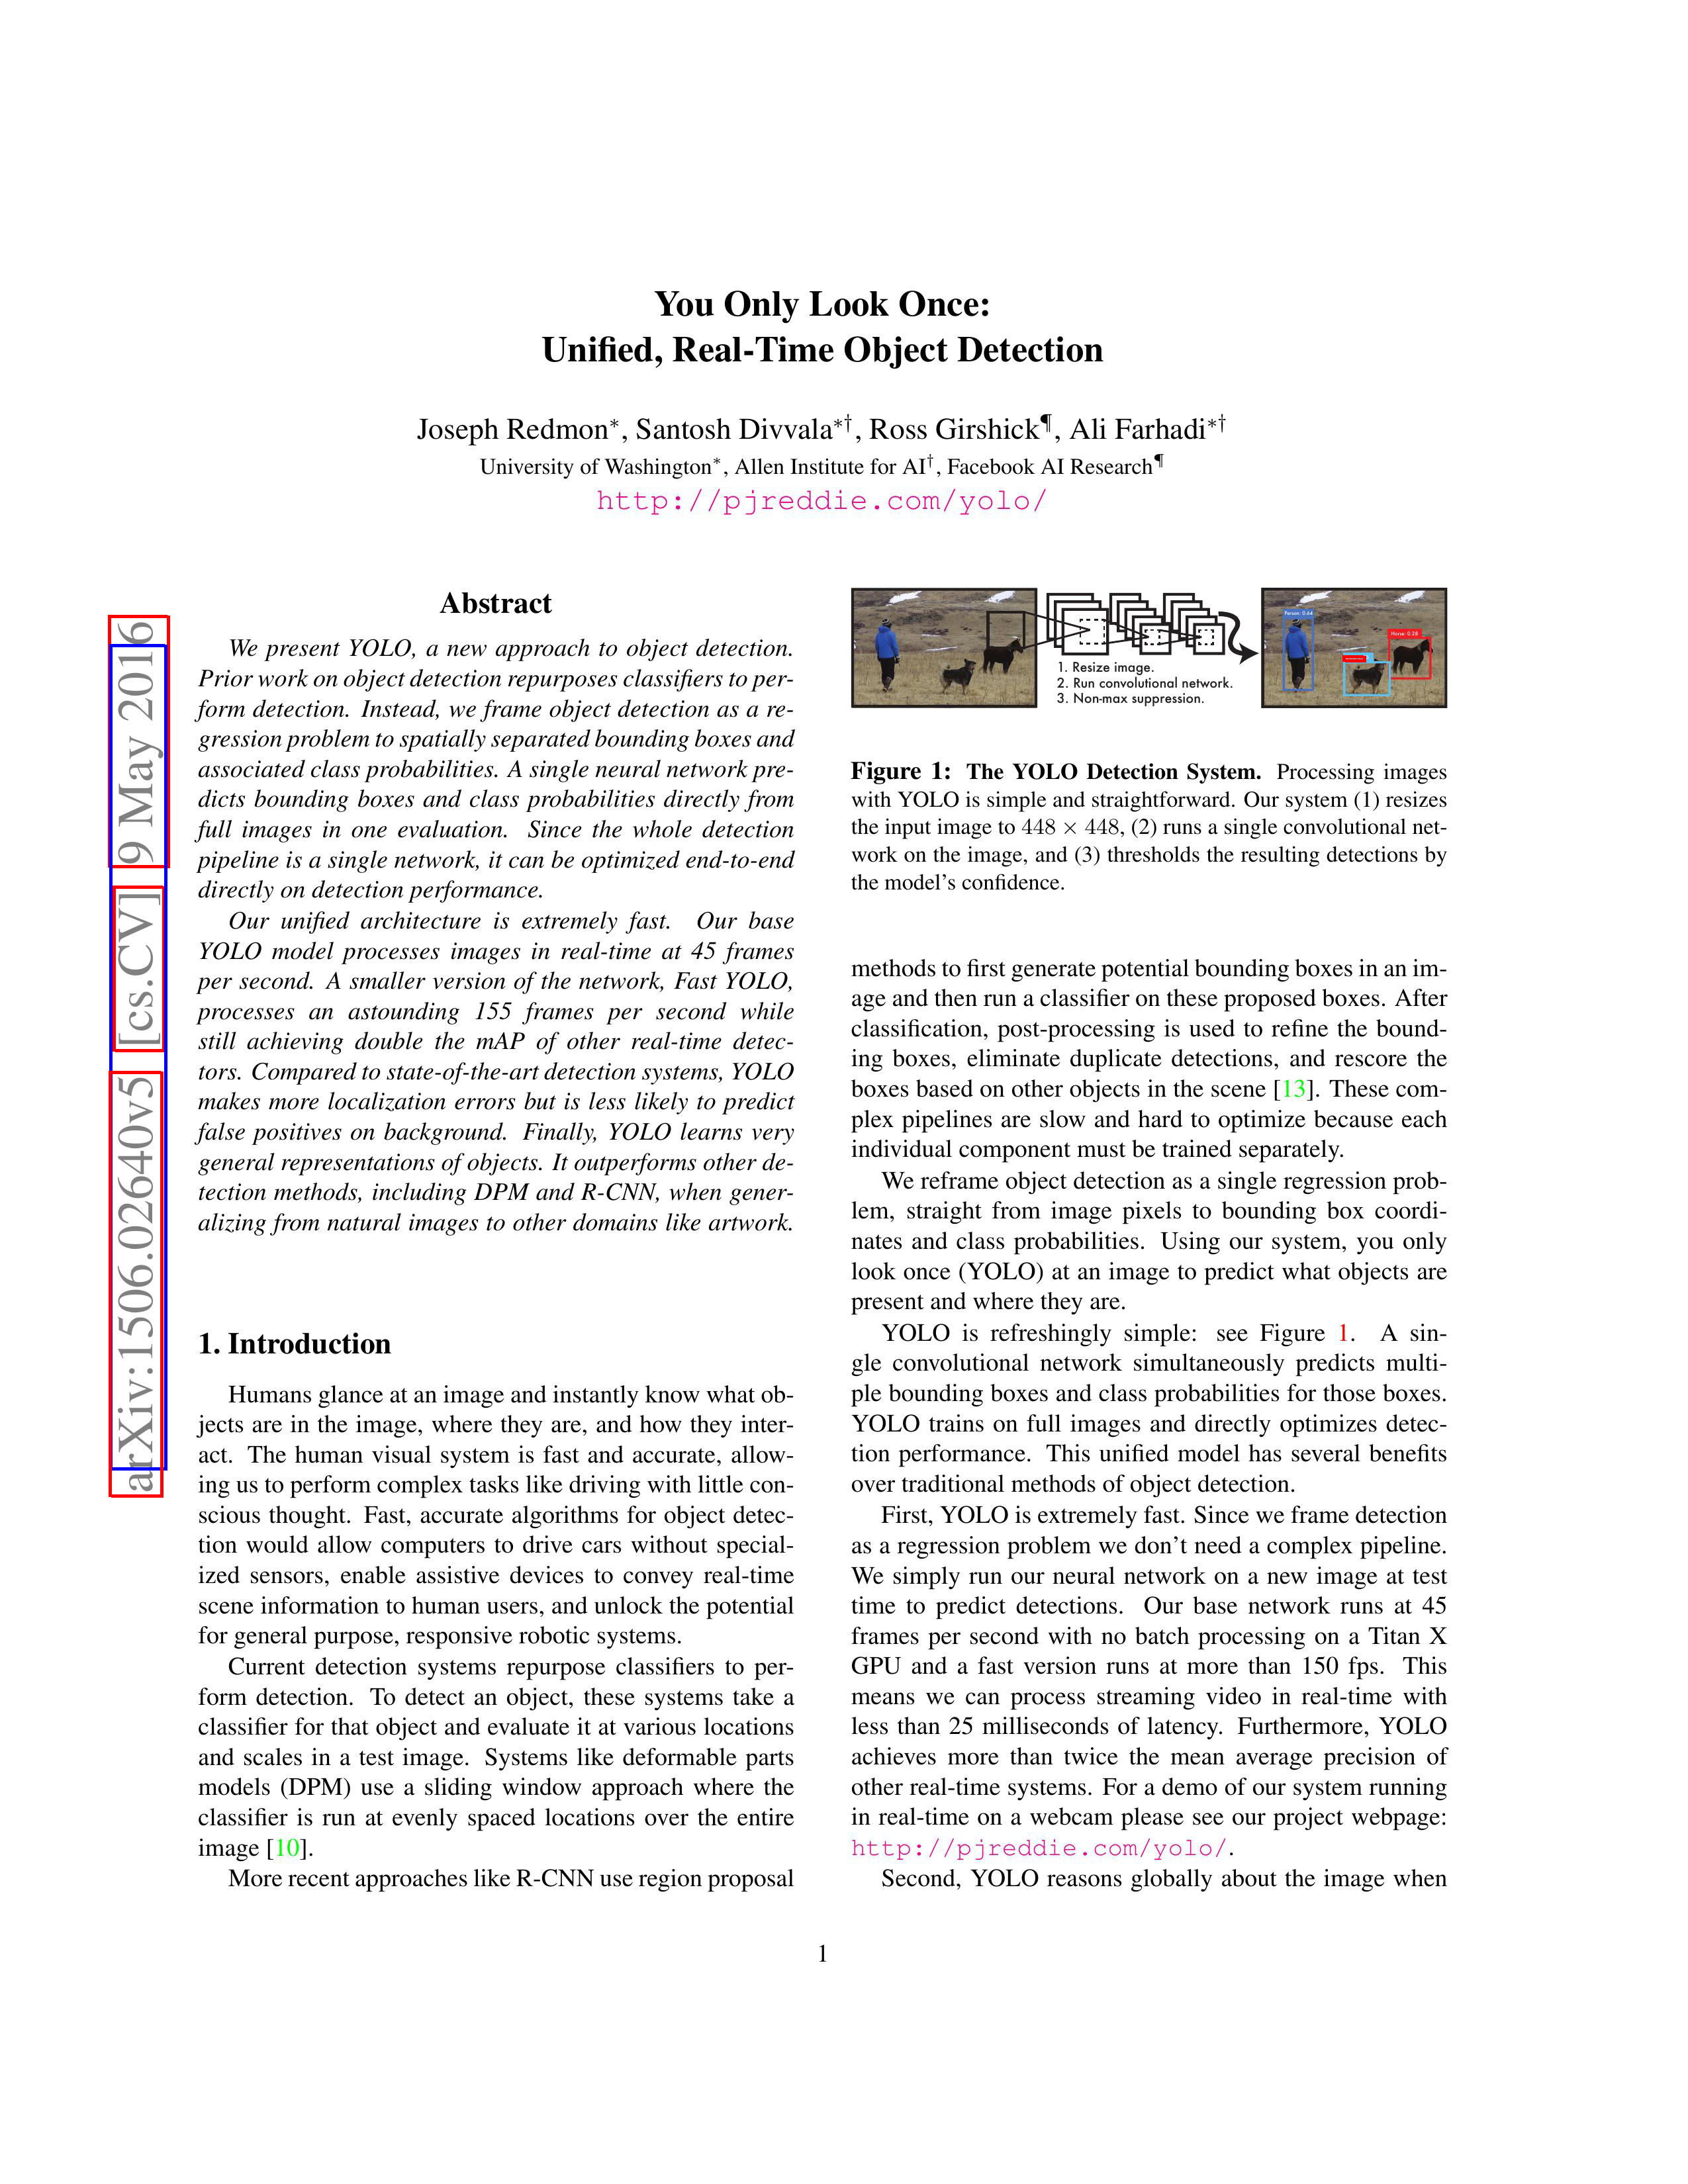

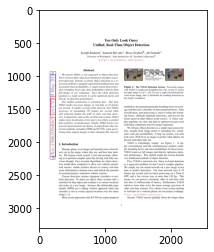

In [31]:
count_row = 142
page = erro_df.iloc[count_row]
image_path =   glob.glob(image_base_path + '/*/' +'/'.join( page['path'].split('/')[-2:]))[0]


draw_box(image_path,page['below_iou_threshold'])

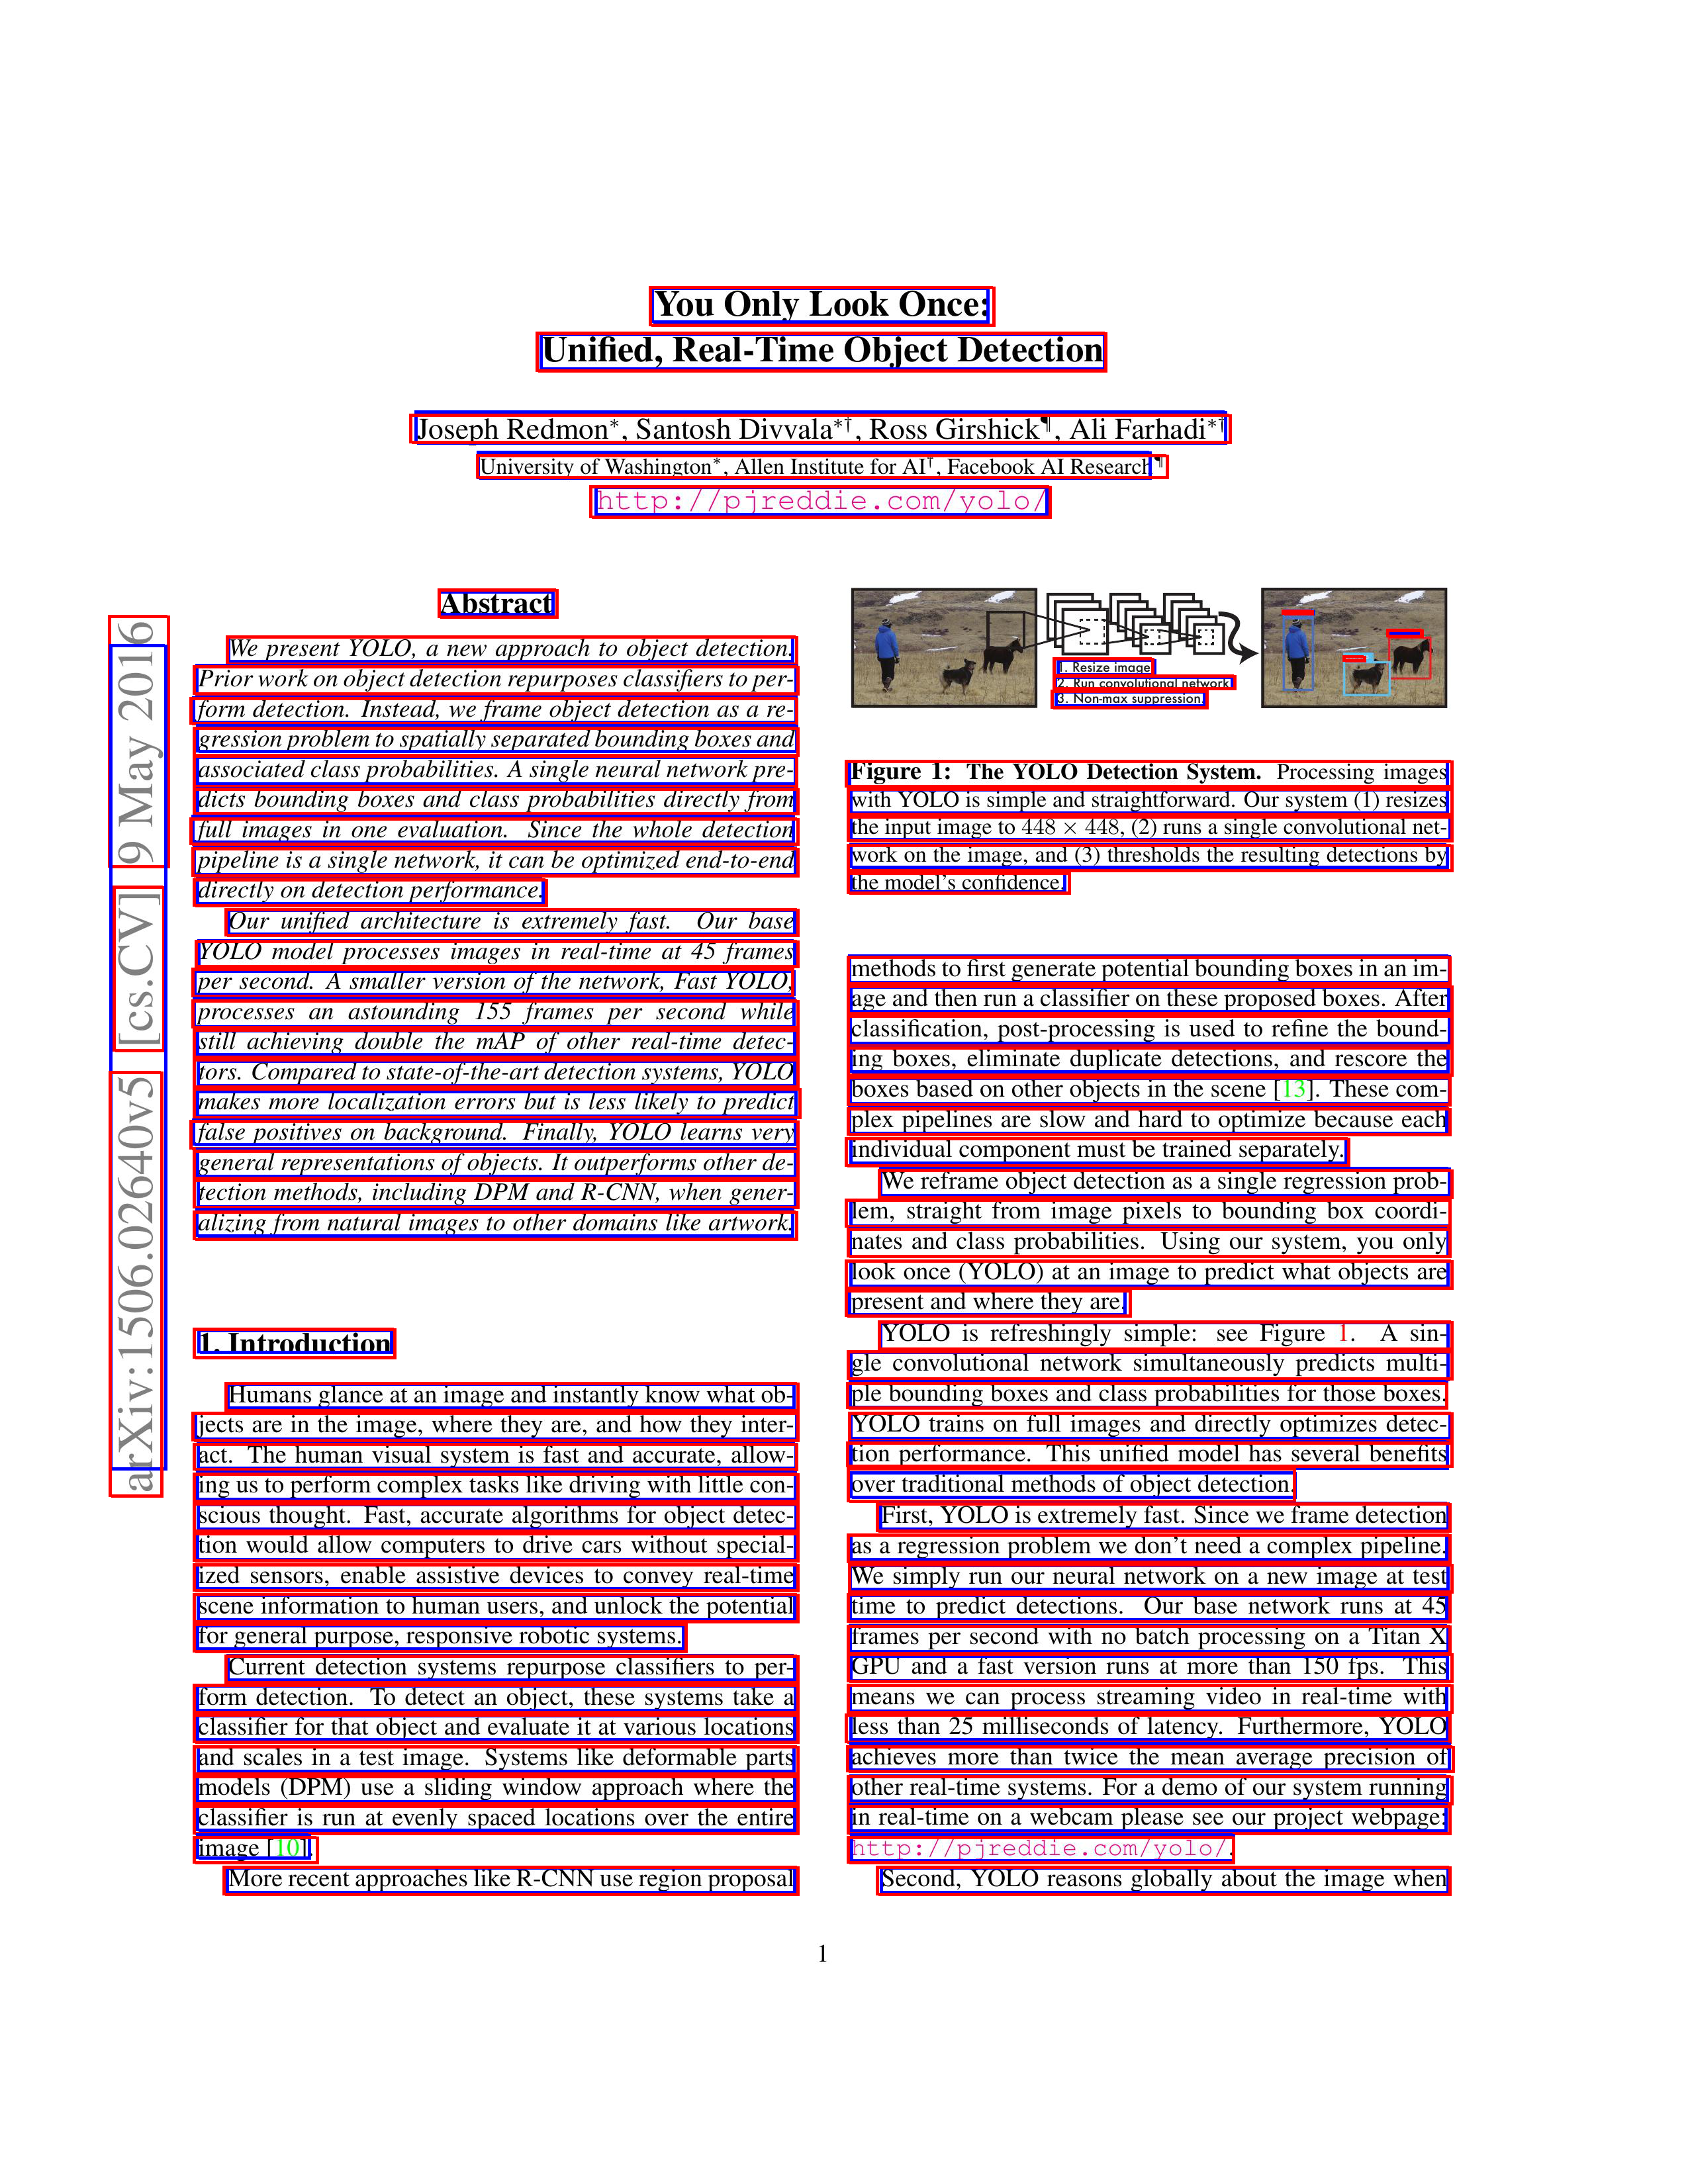

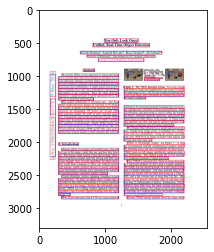

In [32]:
page = erro_df.iloc[count_row]

image_path =   glob.glob(image_base_path + '/*/' +'/'.join( page['path'].split('/')[-2:]))[0]

draw_box(image_path,page['page'])

In [118]:
page['page'][0]

{'ground': {'identifier': '79825087-6dbb-45d9-9f33-a7fb56d00cd6',
  'boundingBox': {'vertices': [{'x': 224, 'y': 168},
    {'x': 555, 'y': 169},
    {'x': 553, 'y': 235},
    {'x': 222, 'y': 235}]},
  'text': 'रिजिस्ट्री सं डी--२२१ '},
 'input': {'boundingBox': {'vertices': [{'x': 218, 'y': 168},
    {'x': 562, 'y': 177},
    {'x': 560, 'y': 239},
    {'x': 217, 'y': 229}]},
  'identifier': 'b6ec495b-8a1e-45ca-b831-9b8fb1fa0ca7',
  'class': 'TEXT',
  'font': {'family': 'Arial Unicode MS', 'size': 61, 'style': 'REGULAR'}},
 'iou': 0.8724697847214359}

In [ ]:
import glob
def get_box(file_index):
    pages = len(input_data['rsp']['outputs'][file_index]['page_info'])
    for page_index in range(pages):
        #try:
        page_image = input_data['rsp']['outputs'][file_index]['page_info'][page_index]
        compare_corrds =   eval_data['rsp']['outputs'][file_index]['pages'][page_index]['iou']
        gt_image = draw_region(image_base_path + page_image,ground_data['rsp']['outputs'][file_index]['pages'][page_index]['words'])
        craft_image = draw_region(image_base_path + page_image,input_data['rsp']['outputs'][file_index]['pages'][page_index]['words'] ,color='blue')
        comapre_image = draw_box(image_base_path + page_image,compare_corrds)
        stiched_image = np.hstack([np.array(gt_image) ,np.array(craft_image)])
        stiched_image = np.hstack([np.array(gt_image) , np.array(comapre_image) ,np.array(craft_image)])
        cv2.imwrite("/home/naresh/word_compare4/"+page_image.split("/")[-1], stiched_image)
        #except:
            #pass

In [ ]:
# files = len(input_data['rsp']['outputs'])
# for file_index in range(files):
#     get_box(file_index)

In [ ]:
files

In [27]:
file_index = 1
page_index = 0

page_image = ground_data['rsp']['outputs'][file_index]['page_info'][page_index]
compare_corrds =   eval_data['rsp']['outputs'][file_index]['pages'][page_index]['iou']

image_path =   glob.glob(image_base_path + '/*/' +'/'.join(page_image.split('/')[-2:]))[0]


gt_image = draw_region(image_path,ground_data['rsp']['outputs'][file_index]['pages'][page_index]['words'])
craft_image = draw_region(image_path,input_data['rsp']['outputs'][file_index]['pages'][page_index]['words'] ,color='blue')
comapre_image = draw_box(image_path,compare_corrds)
compare_df = pd.DataFrame(compare_corrds)
print(compare_df['iou'].mean())
#iou_stats.append(compare_df['iou'].mean())
stiched_image = np.hstack([np.array(gt_image) , np.array(comapre_image) ,np.array(craft_image)])
cv2.imwrite(  'results/' +str(uuid.uuid1()) + '.png', stiched_image)

0.5451286092375974


True

In [53]:
  glob.glob(image_base_path + '/*/' +'/'.join(page_image.split('/')[-2:]))[0]

'/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/word-detector/craft/upload/bengali_3_singlecolumn_fbbf5046-aae5-41d6-ba53-7bd46b6131d8/images/bengali_3_singlecolumn0001-3.jpg'

In [ ]:
|

In [55]:
'/'.join(page_image.split('/')[-4:])

'upload/bengali_3_singlecolumn_ed4f6d6a-9932-4b5f-9edf-27ac4711ec4e/images/bengali_3_singlecolumn0001-3.jpg'

In [ ]:
eval_data

In [ ]:
count_df = pd.DataFrame(iou_errors)
count_df

In [ ]:
iou_df = pd.DataFrame(iou_errors)
iou_df

In [ ]:
def draw_low_iou_threshold(iou_df):
    files = iou_df.file_index.unique()
    for file_index in files:
        file_df = iou_df[iou_df["file_index"]=file_index]
        file_df = iou_df[iou_df["file_index"]=file_index]
        for page_index in range(len(file_df)):
            page = file_df.iloc[page_index]
            draw_box(image_base_path + page['path'],page['below_iou_threshold'])
            

In [ ]:
draw_low_iou_threshold(iou_df)

In [ ]:
iou_row = 4
page = iou_df.iloc[iou_row]
draw_box(image_base_path + page['path'],page['page'])


In [ ]:
page

In [17]:
import glob

0.7025988124509497
0.601006571819934
0.48393338370480876
0.5852264030878426
0.42003097744793333
0.33293411642718546
0.3839200844465262
0.4536467795903851
0.7372501304735408
0.5804906692541848
0.6462470818287032
0.8123518626280684
0.5837043150816414
0.8337538747043461
0.8788138784636409
0.6430444820070004
0.6829850657424514
0.20407153278957982
0.7284434058546301
0.7190202987294967
0.7248349054048995
0.8051936439647219
0.8067061767366431
0.793557786508253
0.6425698810029628
0.6014211736632158
0.6839749188775278
'iou'
8
0
0.8877049180327868
0.6561609140661472
0.6852898267546409
0.7278134485754238
0.4350428766736454
0.4335209240346705
0.7813460616581435
0.7440107691728847
0.4816000843517701
0.601439462441673
0.5266077127406043
0.6295621863943107
0.6449687633620254
0.7931128034655442
0.6568612898116682
0.8059525507536894
0.5031795951613377
0.5342580914477725
'iou'
13
0
0.8003152871521998
0.6954657625483434
0.7203332448684207
0.4471251124316281
0.46915263586134764
0.8207848909516394
0.712931

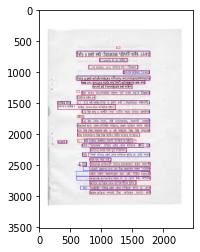

In [52]:
iou_stats = []

to_draw ='words'

for file_index in range(len(eval_data['rsp']['outputs'])) :
    for page_index in range(len(eval_data['rsp']['outputs'][file_index]['pages'])):
        try :
            page_image = ground_data['rsp']['outputs'][file_index]['page_info'][page_index]
            compare_corrds =   eval_data['rsp']['outputs'][file_index]['pages'][page_index]['iou']

            image_path =   glob.glob(image_base_path + '/*/' +'/'.join(page_image.split('/')[-2:]))[0]


            gt_image = draw_region(image_path,ground_data['rsp']['outputs'][file_index]['pages'][page_index][to_draw],color='red')
            craft_image = draw_region(image_path,input_data['rsp']['outputs'][file_index]['pages'][page_index][to_draw] ,color='blue')
            comapre_image = draw_box(image_path,compare_corrds)
            compare_df = pd.DataFrame(compare_corrds)
            print(compare_df['iou'].mean())
            #iou_stats.append(compare_df['iou'].mean())
            stiched_image = np.hstack([np.array(gt_image) , np.array(comapre_image) ,np.array(craft_image)])
            cv2.imwrite('/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/document-processor/evaluator/src/notebooks/results/craft_mag_1/' +str(file_index) + '_' +str(page_index) + '.png', stiched_image)
            
        except Exception as e:
            print(str(e))
            print(file_index)
            print(page_index)
            

In [ ]:
comapre_image

In [ ]:

compare_df = pd.DataFrame(compare_corrds)

In [ ]:
compare_df['iou'].mean()

In [ ]:
len(eval_data['rsp']['outputs']) #[file_index]

In [ ]:
eval_data['rsp'].keys()

0.6861187134341741

In [ ]:
np.mean(iou_stats)

In [ ]:
np.mean(iou_stats)

In [ ]:
8,2,4

0.5331896355570389
0.5911757986732217
0.6203633723763122
0.5620582149400676
0.5488797296908341
0.535142327697838
0.6078407486631073
0.6884819741198223
0.5666216307191195
0.5940801542905321
0.6866600642338573
0.7034852042635412
0.5347262928269113
0.6035566594439823
0.5596672386558638
0.4062571461792611
0.5422557423269335
0.6512537552823257

0.5036370285005956
0.596914331076525
0.6246971532915176
0.5424381227153756
0.5575604059387527
0.5485543730261239
0.5943804339737555
0.6731481219035321
0.5769426378134691
0.5839788432017801
0.6676718033712223
0.6879190446933335
0.5731670231767895
0.5801987258267257
0.5901110920900879
0.38902491717860144
0.5584404078149451
0.6809534628249947


In [ ]:
inputs = pd.DataFrame(ground_data['rsp']['outputs'])


In [ ]:
inputs